Note: check whether I should use bisect_left or bisect??

In [1]:
import os
import pandas as pd
import numpy as np
import re
import json
import bisect
import csv

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DIR_NORM = r"/Users/chenkx/Box Sync/NLP group/2019 n2c2 Challenge/Track 3 (normalization)/Test/norm"
DATA_DIR_PROCESSED = "/Users/chenkx/Desktop/TBIC-not_synced/Negation/notebooks/2010Corpus/explore_i2b2-2010-v5.0-ALL_concepts.csv"
DATA_DIR = r'/Users/chenkx/Box Sync/NLP group/2010 i2b2 challenge - rel'
FILE_SORTER= r"/Users/chenkx/Box Sync/NLP group/2019 n2c2 Challenge/Track 3 (normalization)/Test/test_file_list.txt"
DIR_TEAM_OUT = r"/Users/chenkx/Box Sync/NLP group/2019 n2c2 Challenge/Track 3 (normalization)/top10_outputs"
MAP_DIR = r"/Users/chenkx/Desktop/TBIC-not_synced/Negation/notebooks/2010Corpus/section_mapping_v4_all.csv"
DIR_SEM_TYPE = r'/Users/chenkx/Desktop/TBIC-not_synced/Negation/data/2019/semTypeInfo/'

Load section heading map and prepare functions to extract headings

In [3]:
with open(MAP_DIR, 'r') as f:
    section_map = f.read()
section_map = section_map.split('\n')[1:]
section_map = {i.split(',')[0]:i.split(',')[1] for i in section_map}
len(section_map)

1145

In [4]:
MAP_DIR1 = "/Users/chenkx/Desktop/TBIC-not_synced/Negation/data/simple_header_map.json"
MAP_DIR2 = "/Users/chenkx/Desktop/TBIC-not_synced/Sectionizer/data/section_mapping/sectionTypeMapping.json"
with open(MAP_DIR1, 'r') as f:
    section_map1 = json.load(f)
with open(MAP_DIR2, 'r') as f:
    section_map2_tmp = json.load(f)
section_map2 = {}
# reformat section_map2 to lower case
for i in section_map2_tmp:
    section_map2[i.lower()] = section_map2_tmp[i].lower()
del section_map2_tmp

In [5]:
def header_pattern(txt):
    """
    Return an iterator yielding match objects over all non-overlapping matches
    """
    return re.finditer('(?<=\n)[a-zA-Z -]+(?=[ ]:[\n| ])', txt) # wrong and previously used: (\n[a-zA-Z -]+)(( :\n)|( : ))

In [6]:
def std_header(phrase):
    """
    standardize heading from regex matches.
        1. converting to lower case
        2. trim white space.
    If mapped them to "?": do not consider them as headers 
    If mapped to subsection, date/time, or providers, do not consider them as headers 
    """        
    phrase0 = re.sub(" :$", "", phrase.strip().lower())
    phrase = None
    if phrase0 in section_map1:
        phrase = section_map1[phrase0]
    elif phrase0 in section_map2:
        phrase = section_map2[phrase0]
    if not phrase:
        phrase = phrase0
    if phrase in section_map:
        phrase = section_map[phrase]
    else:
        print(f'Not mapped: {phrase0}')
        return None
        
    if phrase == '?':
        return None

    if phrase == '':
        return None
    
    if phrase == "Subsection" or phrase == "Date/Time" or phrase == "Providers":
        return None
    
    return phrase

In [7]:
def get_all_headings(txt):
    """
    1. Extract regex headings. 
    2. Map them to the normalized section according to the section map
    3. Sort headings based on begin offsets
    :return List[(str, int, int)] 
    """
    all_headings = []
    matches = header_pattern(txt)
    for m in matches:
        match = std_header(m.group(0))
        if match:
            b, e = m.span()
            all_headings.append( (match, b, e) )
    all_headings.sort(key=lambda x:x[1])
    return all_headings

In [8]:
def get_section(x, section_delim, headings):
    s_i = bisect.bisect_left(section_delim, x) - 1 
    if s_i == -1:
        section = 'Unknown/Unclassified'
    else:
        section = [i[0] for i in headings][s_i]
    if section == "?":
        section = "Unknown/Unclassified"
    return section

In [9]:
def get_concept(b, e, txt):
    return txt[b:e+1]

Load corpus and annotations from the 2019 challenge. For each file, also extract sections using regex and the section map

In [10]:
with open(FILE_SORTER, 'r') as f:
    sorter = f.read().split('\n')
sorter = [i for i in sorter if i != ""]

In [11]:
# read from 2019 annotations. Concepts and offsets for each file.
filenames = [i for i in os.listdir(DIR_NORM) if i.endswith('.norm')]
df2019 = pd.DataFrame(columns=['cui_id', 'CUI', 'b', 'e', 'filename'])
for file in sorter:
    # load raw notes
    try:
        with open(os.path.join(DATA_DIR, 'test', 'txt', file+".txt"), 'r') as f:
            text = f.read()
    except FileNotFoundError:
        with open(os.path.join(DATA_DIR, 'train', 'txt', file+".txt"), 'r') as f:
            text = f.read()
    headings = get_all_headings(text)
    section_delim = [i[1] for i in headings]
    
    # load 2019 annotations 
    df = pd.read_csv(os.path.join(DIR_NORM, file+'.norm'), sep='\|\|', index_col = False, names=['cui_id', 'CUI', 'b', 'e'], engine='python')
    df['filename'] = file
    
    # get section information for each concept 
    df['section']= df.b.transform(lambda x: get_section(x, section_delim, headings))
    df['concept'] = df.apply(lambda x: get_concept(x.b, x.e, text), axis=1)
    
    df2019 = pd.concat([df2019, df], ignore_index=True)
df2019.filename = df2019.filename.astype(str)
df2019["CUI-index"] = df2019.index
df2019

Not mapped: - echo


,cui_id,CUI,b,e,filename,section,concept,CUI-index
0,N000,C0019699,232,244,0002,Present illness,HIV positive,0
1,N001,C0238552,280,304,0002,Present illness,left upper quadrant pain,1
2,N002,C0027497,316,322,0002,Present illness,nausea,2
3,N003,C0042963,327,335,0002,Present illness,vomiting,3
4,N004,CUI-less,345,370,0002,Present illness,a long-standing complaint,4
...,...,...,...,...,...,...,...,...
6920,N235,C0376358,6573,6584,920798564,Hospital course,prostate CA,6920
6921,N236,C1827596,643,669,920798564,Chief complaint,HISTORY OF PRESENT ILLNESS,6921
6922,N237,C0212018,7168,7190,920798564,Medications,Niferex 150 milligrams,6922
6923,N193,C0750502,220,231,920798564,Diagnoses,SIGNIFICANT,6923


In [12]:
df2019.section.unique()

array(['Present illness', 'Allergies', 'Medications',
       'Physical examination/Status', 'Laboratory tests',
       'Hospital course', 'Follow-up/Instructions',
       'Unknown/Unclassified', 'Diagnoses', 'Procedures/Surgery',
       'Investigations/Results', 'Past history', 'Problems',
       'Family history', 'Review of systems', 'Chief complaint',
       'Complications', 'Reasons/Indications', 'Social history',
       'Assessment/Plan', 'Patient information/Demographics', 'Nutrition',
       'Addendum', 'Radiology'], dtype=object)

In [13]:
# consolidate Assessment, Plan, Assessment/Plan. and Investigations/Results, Radiology, Laboratory tests. 
# manually correct 0065.txt section = "Advance directive/Code". change them to diagnoses 
df2019.loc[(df2019.section=='Radiology') | (df2019.section=='Laboratory tests'), 'section'] = "Investigations/Results"

In [14]:
print("Percentage of 2019 nomalized concepts that do not have a valid section type:")
print((df2019['section'].value_counts()['Unknown/Unclassified'])/sum(df2019['section'].value_counts()))

Percentage of 2019 nomalized concepts that do not have a valid section type:
0.008664259927797834


Load corpus and assertion annotations from 2010 

In [15]:
# read from 2010. Concepts, assertions, and offsets for each file.
df2010 = pd.read_csv(DATA_DIR_PROCESSED)
df2010[["filename", "item"]] = df2010.id.str.split('::', expand=True)
df2010.set_index("id", inplace=True)
df2010 = df2010[df2010.filename.isin(sorter)]
df2010.filename = pd.Categorical(df2010.filename, sorter)
df2010

,b,e,t,a,c,s,filename,item
id,,,,,,,,
134300717::T1,62,109,problem,present,deep venous thrombosis of right lower extremity,Unknown/Unclassified,134300717,T1
134300717::T2,222,269,problem,present,deep venous thrombosis of right lower extremity,Diagnoses,134300717,T2
134300717::T3,295,314,problem,present,metastatic melanoma,Diagnoses,134300717,T3
134300717::T4,464,483,problem,present,metastatic melanoma,Present illness,134300717,T4
134300717::T5,486,498,problem,present,his melanoma,Present illness,134300717,T5
...,...,...,...,...,...,...,...,...
0194::T161,7414,7425,treatment,NaN,debridement,Procedures/Surgery,0194,T161
0194::T162,7430,7449,treatment,NaN,packing of pancreas,Procedures/Surgery,0194,T162
0194::T163,7567,7579,treatment,NaN,tracheostomy,Procedures/Surgery,0194,T163


In [16]:
print("Percentage of 2010 assertion-annotated concepts that do not have a valid section type:")
print(df2010['s'].value_counts()['Unknown/Unclassified']/sum(df2010['s'].value_counts()))

Percentage of 2010 assertion-annotated concepts that do not have a valid section type:
0.008956315116066533


In [17]:
not_found = []
for i in sorter:
    if not any(df2010.filename.isin([i])):
        not_found.append(i)
if not_found:
    print(not_found)
else:
    print("The dafaframe includes all files in the list.")

The dafaframe includes all files in the list.


In [18]:
# load semantic types for 2019 concepts
semmap = pd.read_table(os.path.join(DIR_SEM_TYPE,'SemGroups_2018.tsv'), sep='|', header=None, names=['c0','sem_type','sem_code','sem_details'])
semref = pd.read_table(os.path.join(DIR_SEM_TYPE, 'TTI_v7_hieracc.tsv'))[['idx', 'sysSemType']]
sysSem = semref.merge(semmap, left_on='sysSemType', right_on='sem_code', how='left').drop(['sysSemType', 'c0', 'sem_code'], axis=1)

Map the annotations from two sources

In [19]:
# merge 2010 (as x) and 2019 (as y) dataset 
merged = pd.merge(df2010, df2019, how="outer", on=['filename', 'b'])
merged = merged.sort_values(['filename', 'b'], ignore_index=True)
# merged.to_csv('tempdf.csv')
merged

,b,e_x,t,a,c,s,filename,item,cui_id,CUI,e_y,section,concept,CUI-index
0,232.0,244.0,problem,present,hiv positive,Present illness,0002,T1,N000,C0019699,244,Present illness,HIV positive,0.0
1,280.0,304.0,problem,present,left upper quadrant pain,Present illness,0002,T2,N001,C0238552,304,Present illness,left upper quadrant pain,1.0
2,316.0,322.0,problem,present,nausea,Present illness,0002,T3,N002,C0027497,322,Present illness,nausea,2.0
3,327.0,335.0,problem,present,vomiting,Present illness,0002,T4,N003,C0042963,335,Present illness,vomiting,3.0
4,345.0,370.0,problem,present,a long standing complaint,Present illness,0002,T5,N004,CUI-less,370,Present illness,a long-standing complaint,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7370,7323.0,7341.0,treatment,NaN,sodium bicarbonate,Medications,920798564,T171,N171,C0074722,7341,Medications,sodium bicarbonate,6860.0
7371,7385.0,7392.0,treatment,NaN,proscar,Medications,920798564,T172,N172,C0678149,7392,Medications,Proscar,6861.0
7372,7418.0,7425.0,treatment,NaN,casodex,Medications,920798564,T173,N173,C0591237,7425,Medications,Casodex,6862.0
7373,7452.0,7462.0,treatment,NaN,nephrocaps,Medications,920798564,T174,N174,C0306965,7462,Medications,Nephrocaps,6863.0


In [20]:
# Remove non-normalized concepts (i.e. keep only concepts from the 2019 corpus) and keep only the reference anntotation. 
gold = merged[merged.CUI.notna()]
gold = gold.sort_values('CUI-index')

# for assertion 
gold.a[(gold.t=='treatment') | (gold.t=='test')] = 'N/A-non-problems'
gold.a = gold.a.fillna("N/A-No_mapping")
gold

<ipython-input-20-d7f6b085e6df>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold.a[(gold.t=='treatment') | (gold.t=='test')] = 'N/A-non-problems'


,b,e_x,t,a,c,s,filename,item,cui_id,CUI,e_y,section,concept,CUI-index
0,232.0,244.0,problem,present,hiv positive,Present illness,0002,T1,N000,C0019699,244,Present illness,HIV positive,0.0
1,280.0,304.0,problem,present,left upper quadrant pain,Present illness,0002,T2,N001,C0238552,304,Present illness,left upper quadrant pain,1.0
2,316.0,322.0,problem,present,nausea,Present illness,0002,T3,N002,C0027497,322,Present illness,nausea,2.0
3,327.0,335.0,problem,present,vomiting,Present illness,0002,T4,N003,C0042963,335,Present illness,vomiting,3.0
4,345.0,370.0,problem,present,a long standing complaint,Present illness,0002,T5,N004,CUI-less,370,Present illness,a long-standing complaint,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7357,6573.0,NaN,NaN,N/A-No_mapping,NaN,NaN,920798564,NaN,N235,C0376358,6584,Hospital course,prostate CA,6920.0
7172,643.0,NaN,NaN,N/A-No_mapping,NaN,NaN,920798564,NaN,N236,C1827596,669,Chief complaint,HISTORY OF PRESENT ILLNESS,6921.0
7366,7168.0,7175.0,treatment,N/A-non-problems,niferex,Medications,920798564,T167,N237,C0212018,7190,Medications,Niferex 150 milligrams,6922.0
7158,220.0,240.0,problem,present,significant problems,Diagnoses,920798564,T4,N193,C0750502,231,Diagnoses,SIGNIFICANT,6923.0


In [21]:
gold = gold.merge(sysSem, left_on='CUI-index', right_on='idx')
gold

,b,e_x,t,a,c,s,filename,item,cui_id,CUI,e_y,section,concept,CUI-index,idx,sem_type,sem_details
0,232.0,244.0,problem,present,hiv positive,Present illness,0002,T1,N000,C0019699,244,Present illness,HIV positive,0.0,0,Phenomena,Laboratory or Test Result
1,280.0,304.0,problem,present,left upper quadrant pain,Present illness,0002,T2,N001,C0238552,304,Present illness,left upper quadrant pain,1.0,1,Disorders,Sign or Symptom
2,316.0,322.0,problem,present,nausea,Present illness,0002,T3,N002,C0027497,322,Present illness,nausea,2.0,2,Disorders,Sign or Symptom
3,327.0,335.0,problem,present,vomiting,Present illness,0002,T4,N003,C0042963,335,Present illness,vomiting,3.0,3,Disorders,Sign or Symptom
4,345.0,370.0,problem,present,a long standing complaint,Present illness,0002,T5,N004,CUI-less,370,Present illness,a long-standing complaint,4.0,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6920,6573.0,NaN,NaN,N/A-No_mapping,NaN,NaN,920798564,NaN,N235,C0376358,6584,Hospital course,prostate CA,6920.0,6920,Disorders,Neoplastic Process
6921,643.0,NaN,NaN,N/A-No_mapping,NaN,NaN,920798564,NaN,N236,C1827596,669,Chief complaint,HISTORY OF PRESENT ILLNESS,6921.0,6921,Disorders,Finding
6922,7168.0,7175.0,treatment,N/A-non-problems,niferex,Medications,920798564,T167,N237,C0212018,7190,Medications,Niferex 150 milligrams,6922.0,6922,Chemicals & Drugs,Organic Chemical
6923,220.0,240.0,problem,present,significant problems,Diagnoses,920798564,T4,N193,C0750502,231,Diagnoses,SIGNIFICANT,6923.0,6923,Concepts & Ideas,Idea or Concept


In [22]:
# gold.to_csv("gold.csv")

## Stats

- Some concepts in the 2019 challenges do not appear in the 2010 challenge. Therefore their assertion status are unknown. 
- Some normalized concepts do not have an assertion status.
- For those concepts that do have an assertion status, % of them can not be assigned to a section. 

In [23]:
gold.section.value_counts()

Hospital course                     2099
Present illness                     1211
Physical examination/Status         1151
Investigations/Results               799
Medications                          423
Past history                         380
Diagnoses                            235
Follow-up/Instructions               151
Procedures/Surgery                   130
Unknown/Unclassified                  60
Review of systems                     60
Allergies                             55
Reasons/Indications                   54
Assessment/Plan                       42
Problems                              25
Chief complaint                       16
Patient information/Demographics      14
Family history                        10
Complications                          4
Social history                         3
Addendum                               2
Nutrition                              1
Name: section, dtype: int64

In [24]:
print(any(gold.section.isna()))

False


In [25]:
len(gold.index)

6925

## Analysis

In [26]:
# set plotting config 
sns.set(rc={"figure.figsize":(32, 10)}) #width=32, height=16
sns.set(font_scale=2) #increase font size of all elements

In [27]:
acc = []
for team in os.listdir(DIR_TEAM_OUT):
    with open(os.path.join(DIR_TEAM_OUT, team), 'r') as f:
        lines = f.readlines()
    if len(lines) != len(gold.index):
        print(team)
        continue
    tmpres = pd.Series(lines).str.strip() == gold.CUI.reset_index(drop=True)
#     tmpres = tmpres.groupby(['s'])['out'].sum().rename_axis(['Assertion']).reset_index(name=team[11:-4])
#     res = pd.merge(res, tmpres, how='outer', on=['Assertion'])
    acc.append((team[11:-4], tmpres.sum()/len(gold.index)))

In [28]:
acc.sort(key=lambda x: -x[1])
print("Micro accuracy:")
acc

Micro accuracy:


[('TTI', 0.8525631768953068),
 ('KP', 0.8193501805054152),
 ('UAZ', 0.8166064981949458),
 ('Ali', 0.8105415162454873),
 ('MDQ', 0.8101083032490974),
 ('UWM', 0.8079422382671481),
 ('UAv', 0.8012996389891697),
 ('ezDI', 0.8005776173285198),
 ('MIT', 0.7961010830324909),
 ('NaCT', 0.7956678700361011)]

In [29]:
len(gold.index)

6925

In [30]:
gold

,b,e_x,t,a,c,s,filename,item,cui_id,CUI,e_y,section,concept,CUI-index,idx,sem_type,sem_details
0,232.0,244.0,problem,present,hiv positive,Present illness,0002,T1,N000,C0019699,244,Present illness,HIV positive,0.0,0,Phenomena,Laboratory or Test Result
1,280.0,304.0,problem,present,left upper quadrant pain,Present illness,0002,T2,N001,C0238552,304,Present illness,left upper quadrant pain,1.0,1,Disorders,Sign or Symptom
2,316.0,322.0,problem,present,nausea,Present illness,0002,T3,N002,C0027497,322,Present illness,nausea,2.0,2,Disorders,Sign or Symptom
3,327.0,335.0,problem,present,vomiting,Present illness,0002,T4,N003,C0042963,335,Present illness,vomiting,3.0,3,Disorders,Sign or Symptom
4,345.0,370.0,problem,present,a long standing complaint,Present illness,0002,T5,N004,CUI-less,370,Present illness,a long-standing complaint,4.0,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6920,6573.0,NaN,NaN,N/A-No_mapping,NaN,NaN,920798564,NaN,N235,C0376358,6584,Hospital course,prostate CA,6920.0,6920,Disorders,Neoplastic Process
6921,643.0,NaN,NaN,N/A-No_mapping,NaN,NaN,920798564,NaN,N236,C1827596,669,Chief complaint,HISTORY OF PRESENT ILLNESS,6921.0,6921,Disorders,Finding
6922,7168.0,7175.0,treatment,N/A-non-problems,niferex,Medications,920798564,T167,N237,C0212018,7190,Medications,Niferex 150 milligrams,6922.0,6922,Chemicals & Drugs,Organic Chemical
6923,220.0,240.0,problem,present,significant problems,Diagnoses,920798564,T4,N193,C0750502,231,Diagnoses,SIGNIFICANT,6923.0,6923,Concepts & Ideas,Idea or Concept


In [31]:

gold[['section', 'sem_type']]

,section,sem_type
0,Present illness,Phenomena
1,Present illness,Disorders
2,Present illness,Disorders
3,Present illness,Disorders
4,Present illness,NaN
...,...,...
6920,Hospital course,Disorders
6921,Chief complaint,Disorders
6922,Medications,Chemicals & Drugs
6923,Diagnoses,Concepts & Ideas


### By section

In [32]:
assert not any(gold.section.isna())

In [33]:
res = gold.section.value_counts().rename_axis(['Section']).reset_index(name='counts')
for team in os.listdir(DIR_TEAM_OUT):
    with open(os.path.join(DIR_TEAM_OUT, team), 'r') as f:
        lines = f.readlines()
    if len(lines) != len(gold.index):
        print(team)
        continue
    tmpres = pd.DataFrame({'section':gold.section.reset_index(drop=True), 'out':pd.Series(lines).str.strip() == gold.CUI.reset_index(drop=True)})
    tmpres = tmpres.groupby(['section'])['out'].sum().rename_axis(['Section']).reset_index(name=team[11:-4])
    res = pd.merge(res, tmpres, how='outer', on=['Section'])
res = res[["Section", "counts"]+[x[0] for x in acc]]
print("Number of correct normalization:")
res

Number of correct normalization:


,Section,counts,TTI,KP,UAZ,Ali,MDQ,UWM,UAv,ezDI,MIT,NaCT
0,Hospital course,2099,1690,1635,1635,1614,1612,1610,1553,1570,1565,1583
1,Present illness,1211,1065,999,997,996,983,991,983,988,958,981
2,Physical examination/Status,1151,1007,968,973,940,959,968,960,947,950,895
3,Investigations/Results,799,678,655,655,665,670,649,644,661,650,666
4,Medications,423,384,376,376,372,365,371,369,373,376,364
5,Past history,380,342,322,326,329,322,316,331,332,326,326
6,Diagnoses,235,214,204,194,193,197,192,202,189,192,199
7,Follow-up/Instructions,151,128,134,122,123,125,128,125,124,124,123
8,Procedures/Surgery,130,105,98,103,102,99,98,101,86,94,96
9,Unknown/Unclassified,60,51,54,50,50,53,48,51,51,51,50


In [34]:
res.iloc[:, 2:] = res.iloc[:, 2:].apply(lambda x: x/res.counts, axis=0)
print("Accuracy:")
res

Accuracy:


,Section,counts,TTI,KP,UAZ,Ali,MDQ,UWM,UAv,ezDI,MIT,NaCT
0,Hospital course,2099,0.805145,0.778942,0.778942,0.768938,0.767985,0.767032,0.739876,0.747975,0.745593,0.754169
1,Present illness,1211,0.879438,0.824938,0.823287,0.822461,0.811726,0.818332,0.811726,0.815855,0.791082,0.810074
2,Physical examination/Status,1151,0.874891,0.841008,0.845352,0.816681,0.833189,0.841008,0.834057,0.822763,0.825369,0.777585
3,Investigations/Results,799,0.848561,0.819775,0.819775,0.832290,0.838548,0.812265,0.806008,0.827284,0.813517,0.833542
4,Medications,423,0.907801,0.888889,0.888889,0.879433,0.862884,0.877069,0.872340,0.881797,0.888889,0.860520
5,Past history,380,0.900000,0.847368,0.857895,0.865789,0.847368,0.831579,0.871053,0.873684,0.857895,0.857895
6,Diagnoses,235,0.910638,0.868085,0.825532,0.821277,0.838298,0.817021,0.859574,0.804255,0.817021,0.846809
7,Follow-up/Instructions,151,0.847682,0.887417,0.807947,0.814570,0.827815,0.847682,0.827815,0.821192,0.821192,0.814570
8,Procedures/Surgery,130,0.807692,0.753846,0.792308,0.784615,0.761538,0.753846,0.776923,0.661538,0.723077,0.738462
9,Unknown/Unclassified,60,0.850000,0.900000,0.833333,0.833333,0.883333,0.800000,0.850000,0.850000,0.850000,0.833333


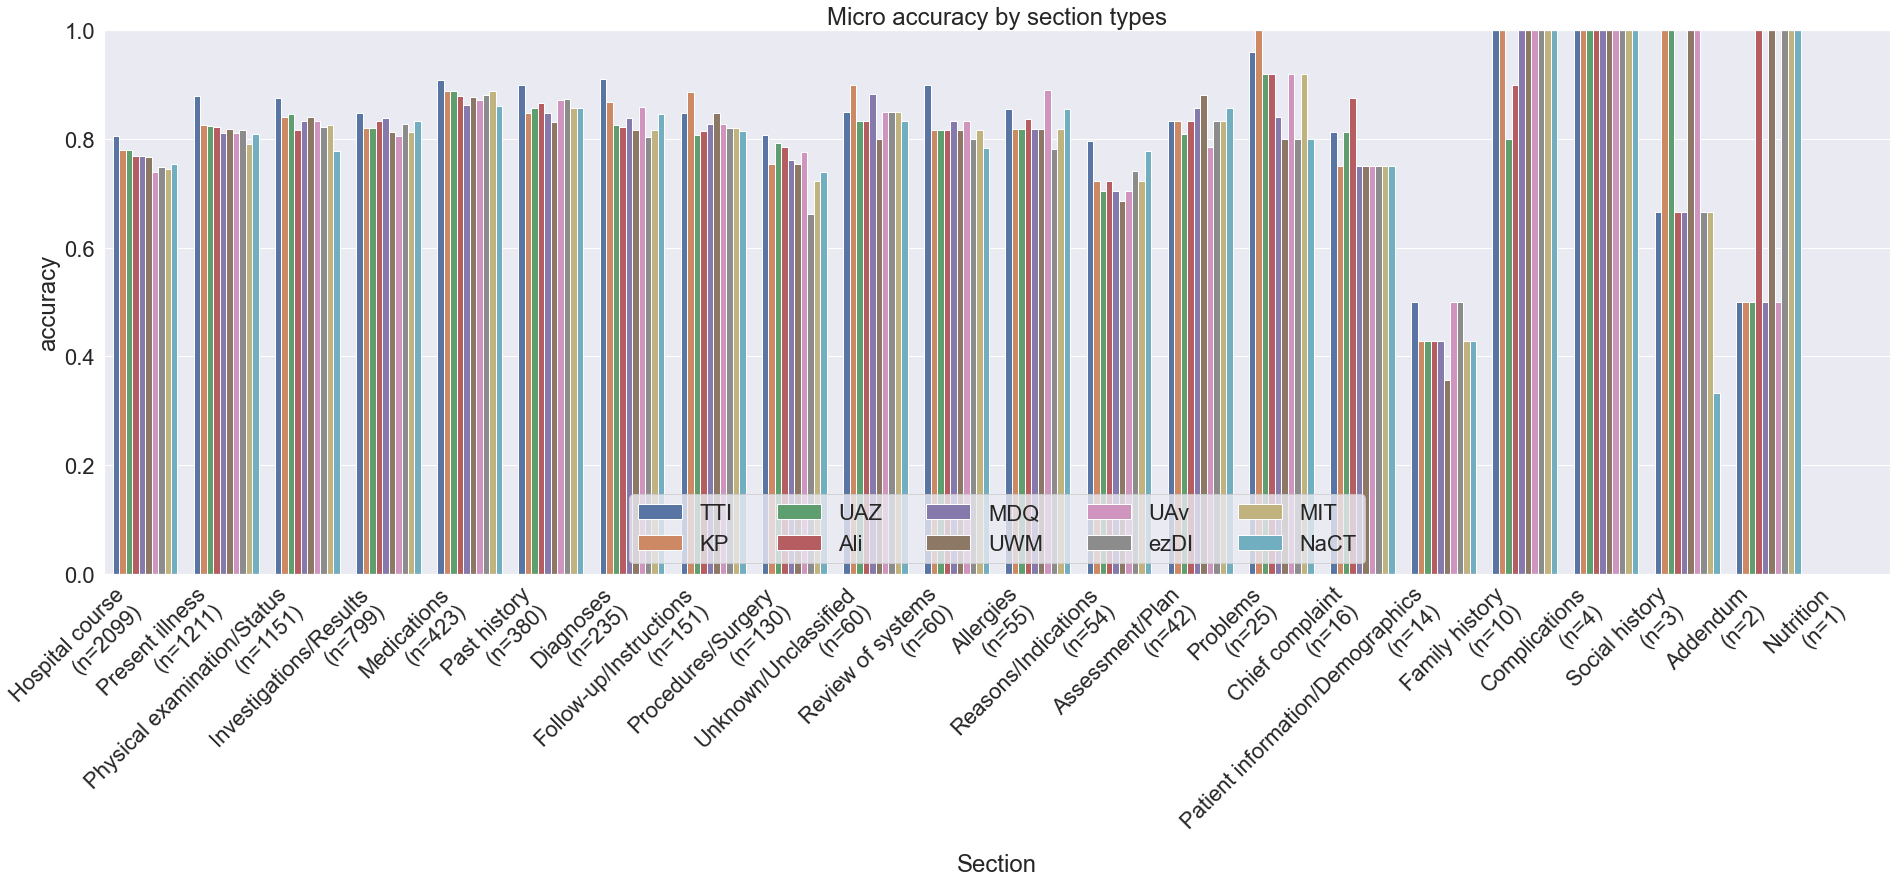

In [35]:
plotdata = pd.melt(res, id_vars=['Section', 'counts'], value_vars=[x[0] for x in acc], var_name='team', value_name='accuracy')
ax = sns.barplot(x= 'Section', y='accuracy', hue='team', data=plotdata)
plt.legend(loc='lower center', ncol=5) # bbox_to_anchor=(0.5, 1.05)
plt.ylim(0,1)
plt.title('Micro accuracy by section types')
ax.set_xticklabels([f'{res.Section[i]}\n(n={res.counts[i]})' for i in range(len(res.index))], ha='right', rotation=45)

plt.savefig("Accuracy-by-section.png", bbox_inches='tight')
plt.show()

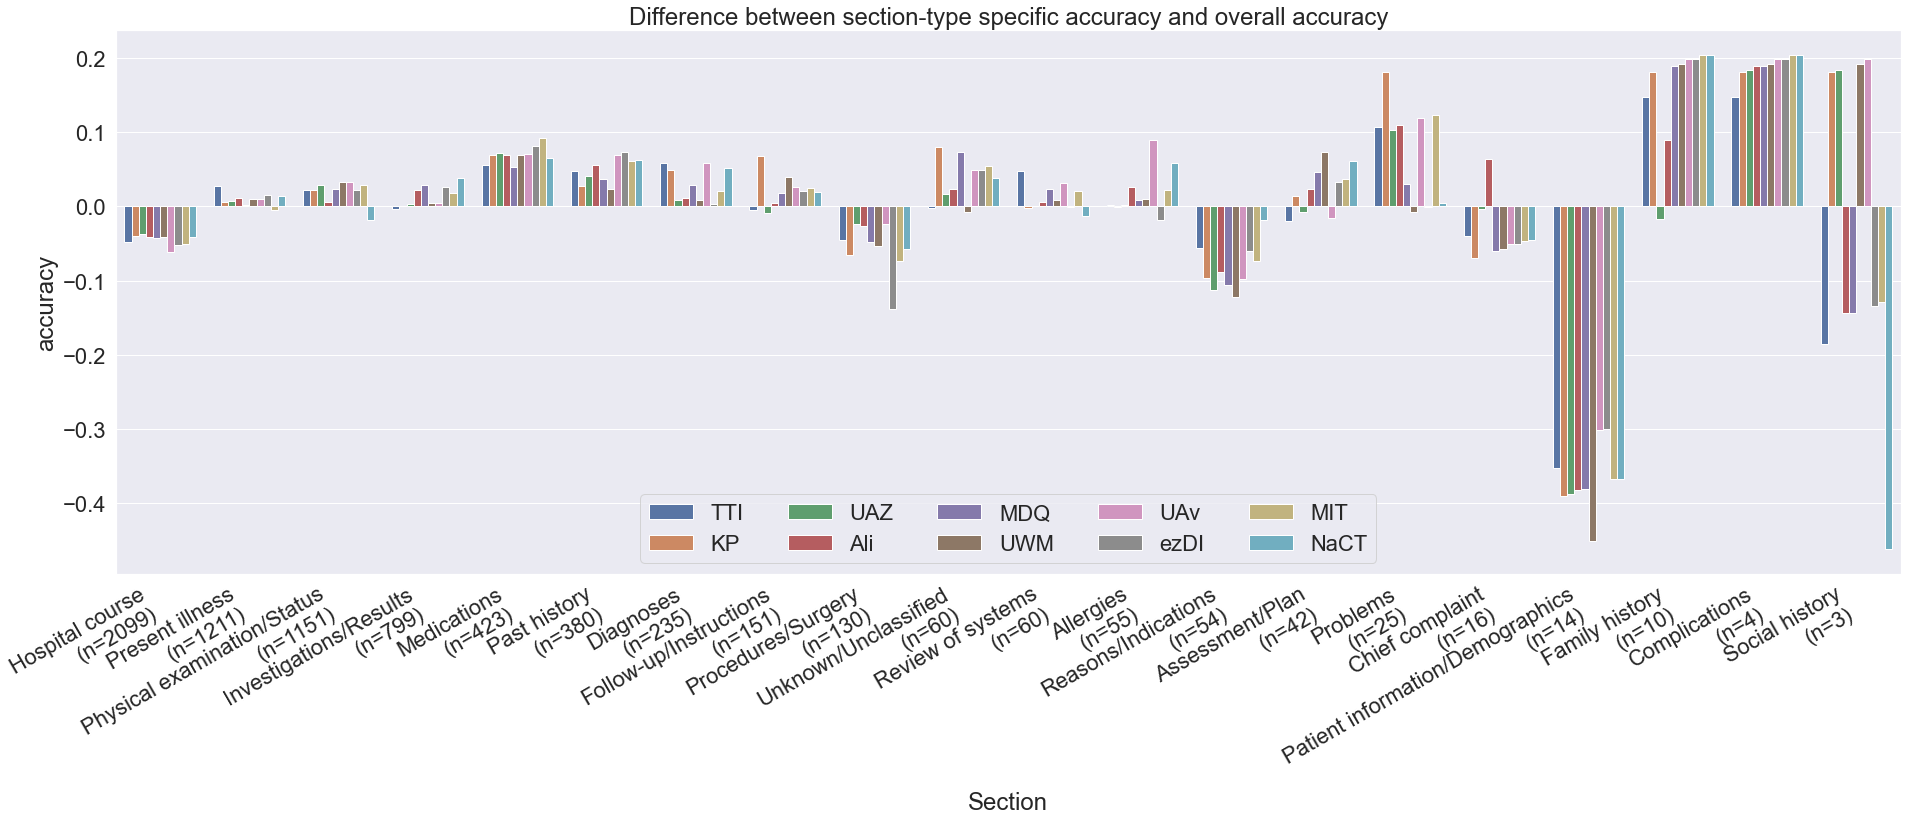

In [36]:
res_diff = res.copy()
res_diff.iloc[:, 2:] = res.iloc[:, 2:].apply(lambda x:x-[x[1] for x in acc], axis=1)
res_diff = res_diff[~res_diff.Section.isin(['Addendum', 'Nutrition'])].reset_index(drop=True)

plotdata = pd.melt(res_diff, id_vars=['Section', 'counts'], value_vars=[x[0] for x in acc], var_name='team', value_name='accuracy')
ax = sns.barplot(x= 'Section', y='accuracy', hue='team', data=plotdata)
plt.legend(loc='lower center', ncol=5) # bbox_to_anchor=(0.5, 1.05)
plt.title('Difference between section-type specific accuracy and overall accuracy')
ax.set_xticklabels([f'{res_diff.Section[i]}\n(n={res_diff.counts[i]})' for i in range(len(res_diff.index))], ha='right', rotation=30)

plt.savefig("Accuracy-diff-micro-by-section.png", bbox_inches='tight')
plt.show()

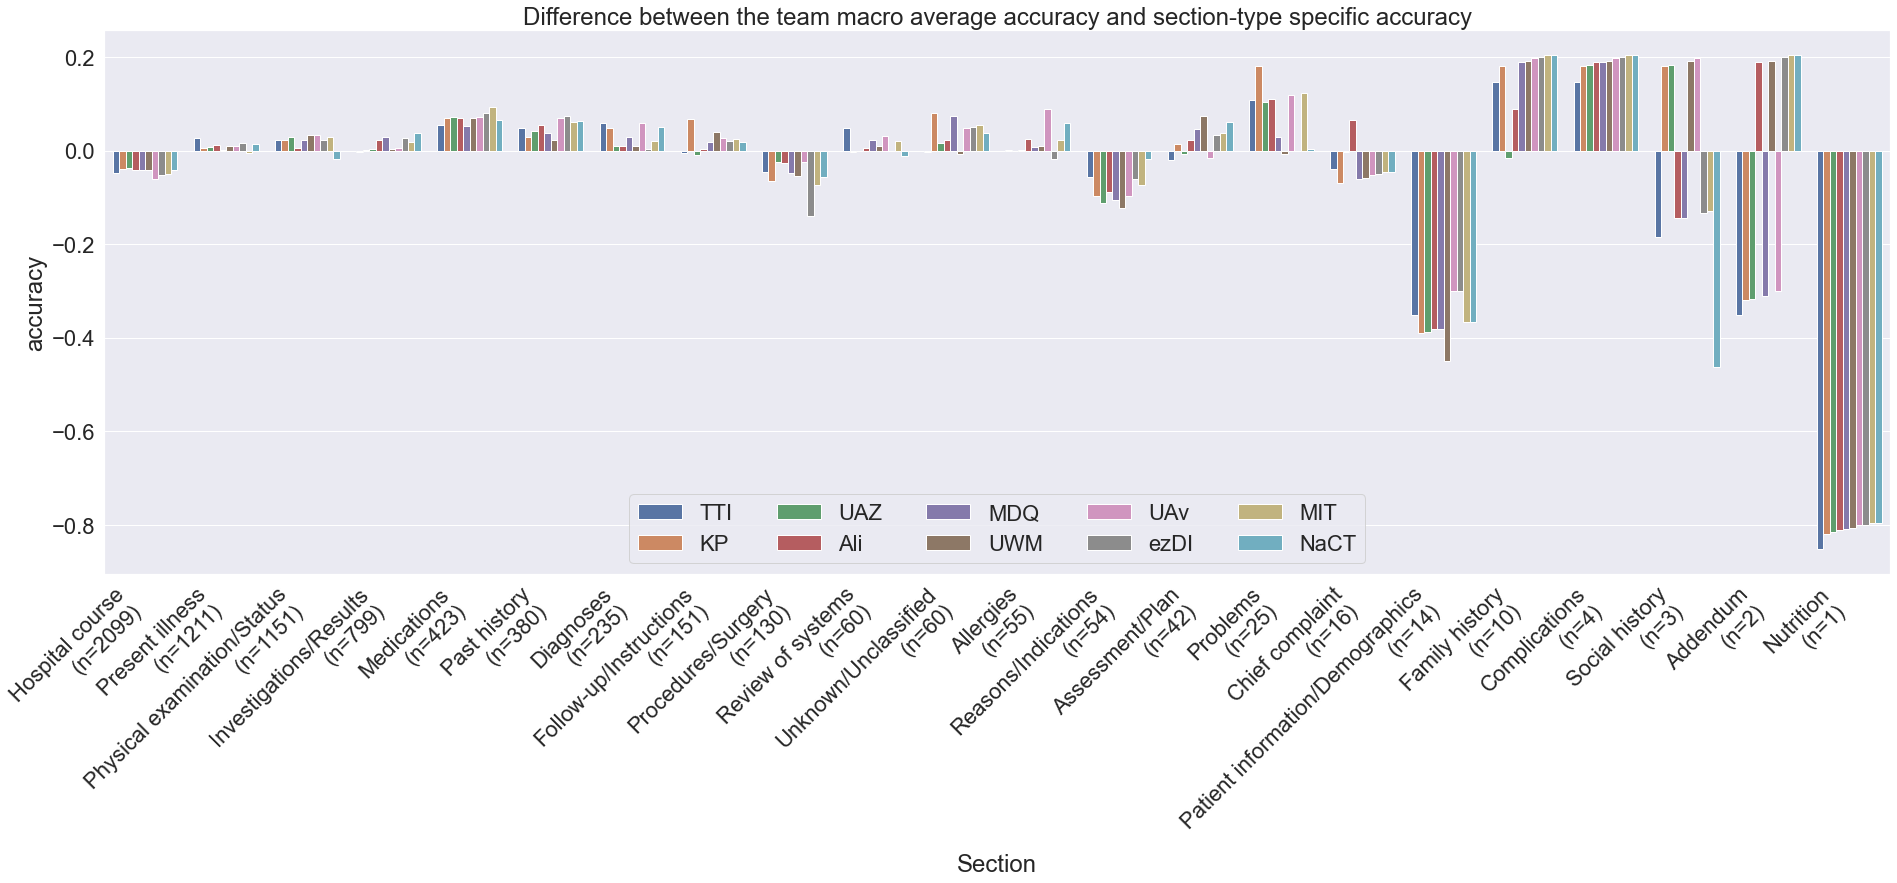

In [365]:
plotdata = res.copy()
plotdata.iloc[:, 2:] = res.iloc[:, 2:].apply(lambda x:x-res.mean(axis=0)[1:], axis=1)

plotdata = pd.melt(res_diff, id_vars=['Section', 'counts'], value_vars=[x[0] for x in acc], var_name='team', value_name='accuracy')
ax = sns.barplot(x= 'Section', y='accuracy', hue='team', data=plotdata)
plt.legend(loc='lower center', ncol=5) # bbox_to_anchor=(0.5, 1.05)
plt.title('Difference between the team macro average accuracy and section-type specific accuracy')
ax.set_xticklabels([f'{res.Section[i]}\n(n={res.counts[i]})' for i in range(len(res.index))], ha='right', rotation=45)

plt.savefig("Accuracy-diff-macro-by-section.png", bbox_inches='tight')
plt.show()

### By assertion types

In [366]:
res = gold.a.value_counts().rename_axis(['Assertion']).reset_index(name='counts')
for team in os.listdir(DIR_TEAM_OUT):
    with open(os.path.join(DIR_TEAM_OUT, team), 'r') as f:
        lines = f.readlines()
    if len(lines) != len(gold.index):
        print(team)
        continue
    tmpres = pd.DataFrame({'s':gold.a.reset_index(drop=True), 'out':pd.Series(lines).reset_index(drop=True).str.strip() == gold.CUI.reset_index(drop=True)})
    tmpres = tmpres.groupby(['s'])['out'].sum().rename_axis(['Assertion']).reset_index(name=team[11:-4])
    res = pd.merge(res, tmpres, how='outer', on=['Assertion'])
res = res[["Assertion", "counts"]+[x[0] for x in acc]]
res

,Assertion,counts,TTI,KP,UAZ,Ali,MDQ,UWM,UAv,ezDI,MIT,NaCT
0,N/A-non-problems,2816,2404,2325,2312,2320,2295,2307,2251,2287,2310,2301
1,N/A-No_mapping,1881,1540,1455,1459,1433,1442,1437,1436,1401,1382,1363
2,present,1475,1297,1250,1237,1217,1219,1208,1217,1209,1190,1211
3,absent,579,517,500,506,499,507,504,503,504,486,486
4,possible,91,68,68,69,70,71,64,65,68,69,73
5,hypothetical,42,38,38,37,37,37,37,37,38,38,37
6,conditional,27,26,24,23,24,25,24,26,24,24,26
7,associated_with_someone_else,14,14,14,12,13,14,14,14,13,14,13


In [367]:
res = res.iloc[2:, :]
res

,Assertion,counts,TTI,KP,UAZ,Ali,MDQ,UWM,UAv,ezDI,MIT,NaCT
2,present,1475,1297,1250,1237,1217,1219,1208,1217,1209,1190,1211
3,absent,579,517,500,506,499,507,504,503,504,486,486
4,possible,91,68,68,69,70,71,64,65,68,69,73
5,hypothetical,42,38,38,37,37,37,37,37,38,38,37
6,conditional,27,26,24,23,24,25,24,26,24,24,26
7,associated_with_someone_else,14,14,14,12,13,14,14,14,13,14,13


In [368]:
acc = []
for team in res.columns[2:]:
    acc.append((team, res[team].sum()/res.counts.sum()))
acc

[('TTI', 0.8797127468581688),
 ('KP', 0.8500897666068222),
 ('UAZ', 0.8456014362657092),
 ('Ali', 0.8348294434470377),
 ('MDQ', 0.8406642728904847),
 ('UWM', 0.8307899461400359),
 ('UAv', 0.8357271095152603),
 ('ezDI', 0.8330341113105925),
 ('MIT', 0.8173249551166966),
 ('NaCT', 0.8285457809694794)]

In [369]:
res.iloc[:, 2:] = res.iloc[:, 2:].apply(lambda x: x/res.counts, axis=0)
res

/Users/chenkx/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


,Assertion,counts,TTI,KP,UAZ,Ali,MDQ,UWM,UAv,ezDI,MIT,NaCT
2,present,1475,0.879322,0.847458,0.838644,0.825085,0.826441,0.818983,0.825085,0.819661,0.806780,0.821017
3,absent,579,0.892919,0.863558,0.873921,0.861831,0.875648,0.870466,0.868739,0.870466,0.839378,0.839378
4,possible,91,0.747253,0.747253,0.758242,0.769231,0.780220,0.703297,0.714286,0.747253,0.758242,0.802198
5,hypothetical,42,0.904762,0.904762,0.880952,0.880952,0.880952,0.880952,0.880952,0.904762,0.904762,0.880952
6,conditional,27,0.962963,0.888889,0.851852,0.888889,0.925926,0.888889,0.962963,0.888889,0.888889,0.962963
7,associated_with_someone_else,14,1.000000,1.000000,0.857143,0.928571,1.000000,1.000000,1.000000,0.928571,1.000000,0.928571


In [370]:
len(res.index)

6

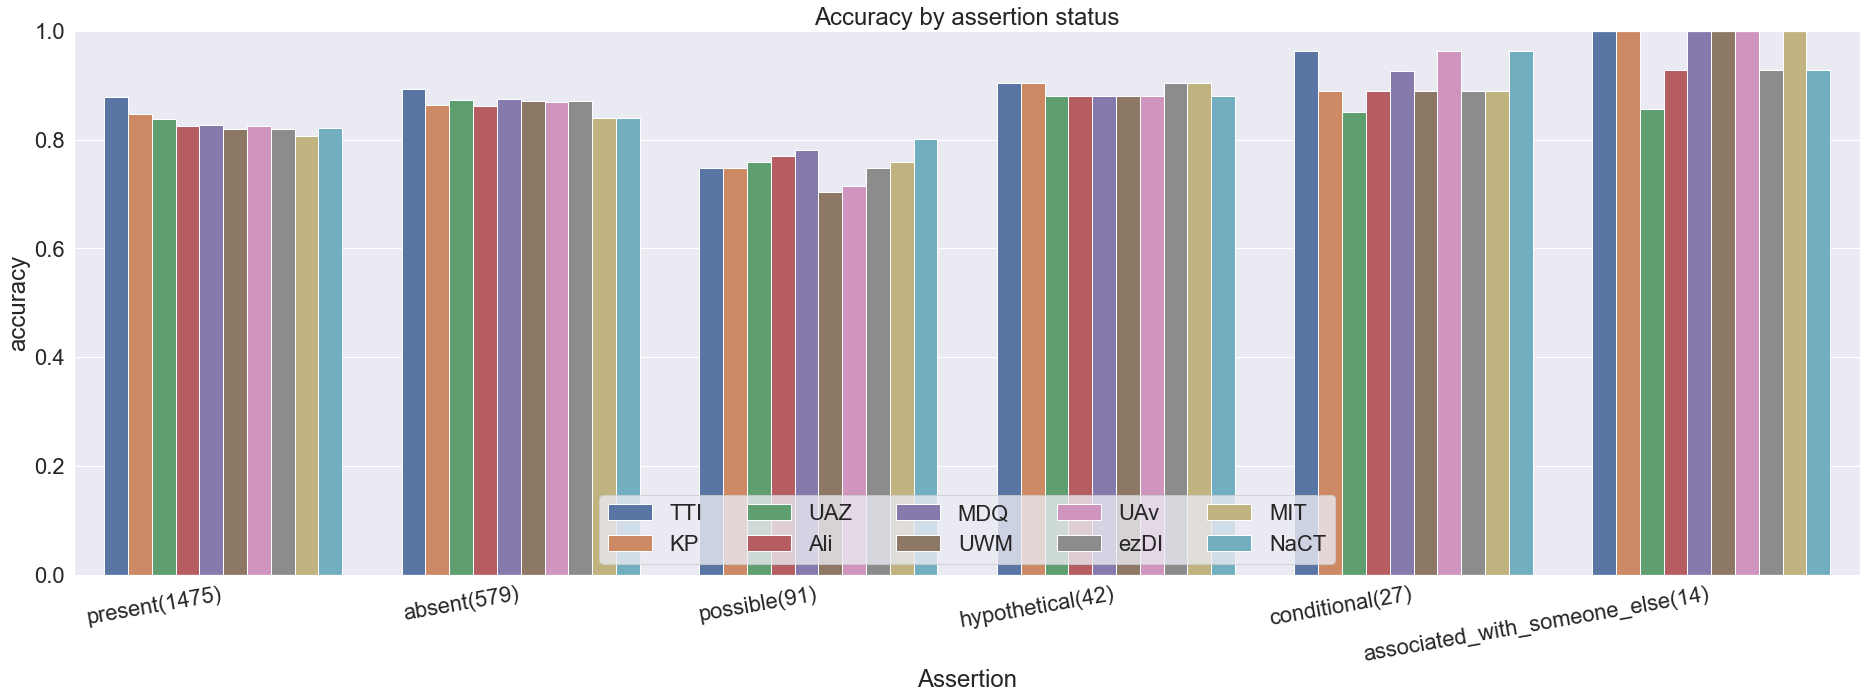

In [371]:
plotdata = pd.melt(res, id_vars=['Assertion', 'counts'], value_vars=[x[0] for x in acc], var_name='team', value_name='accuracy')
ax = sns.barplot(x= 'Assertion', y='accuracy', hue='team', data=plotdata)
ax.tick_params(axis='x', rotation=60)
plt.legend(loc='lower center', ncol=5) # bbox_to_anchor=(0.5, 1.05)
plt.ylim(0,1)
plt.title('Accuracy by assertion status')
ax.set_xticklabels([f'{res.Assertion[i]}({res.counts[i]})' for i in range(2,len(res.index)+2)], ha='right', rotation=10)

plt.savefig("Accuracy-by-assertion-status.png", bbox_inches='tight')
plt.show()

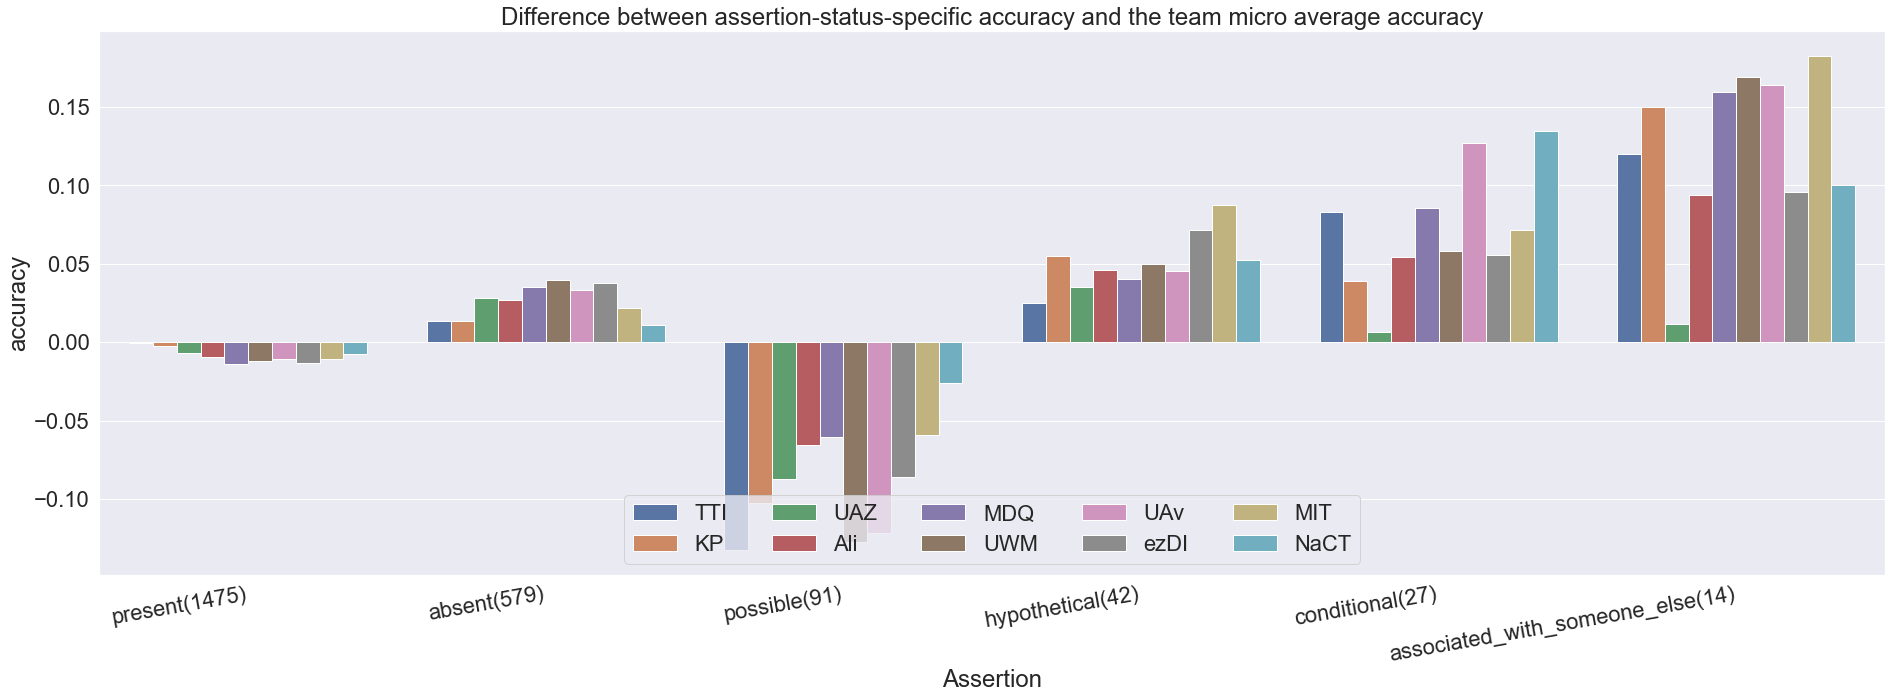

In [372]:
res_diff = res.copy()
res_diff.iloc[:, 2:] = res.iloc[:, 2:].apply(lambda x:x-[x[1] for x in acc], axis=1)

plotdata = pd.melt(res_diff, id_vars=['Assertion', 'counts'], value_vars=[x[0] for x in acc], var_name='team', value_name='accuracy')
ax = sns.barplot(x= 'Assertion', y='accuracy', hue='team', data=plotdata)
ax.tick_params(axis='x', rotation=60)
plt.legend(loc='lower center', ncol=5) # bbox_to_anchor=(0.5, 1.05)
plt.title('Difference between assertion-status-specific accuracy and the team micro average accuracy')
ax.set_xticklabels([f'{res.Assertion[i]}({res.counts[i]})' for i in range(2,len(res.index)+2)], ha='right', rotation=10)

plt.savefig("Accuracy-diff-micro-by-assertion.png", bbox_inches='tight')
plt.show()

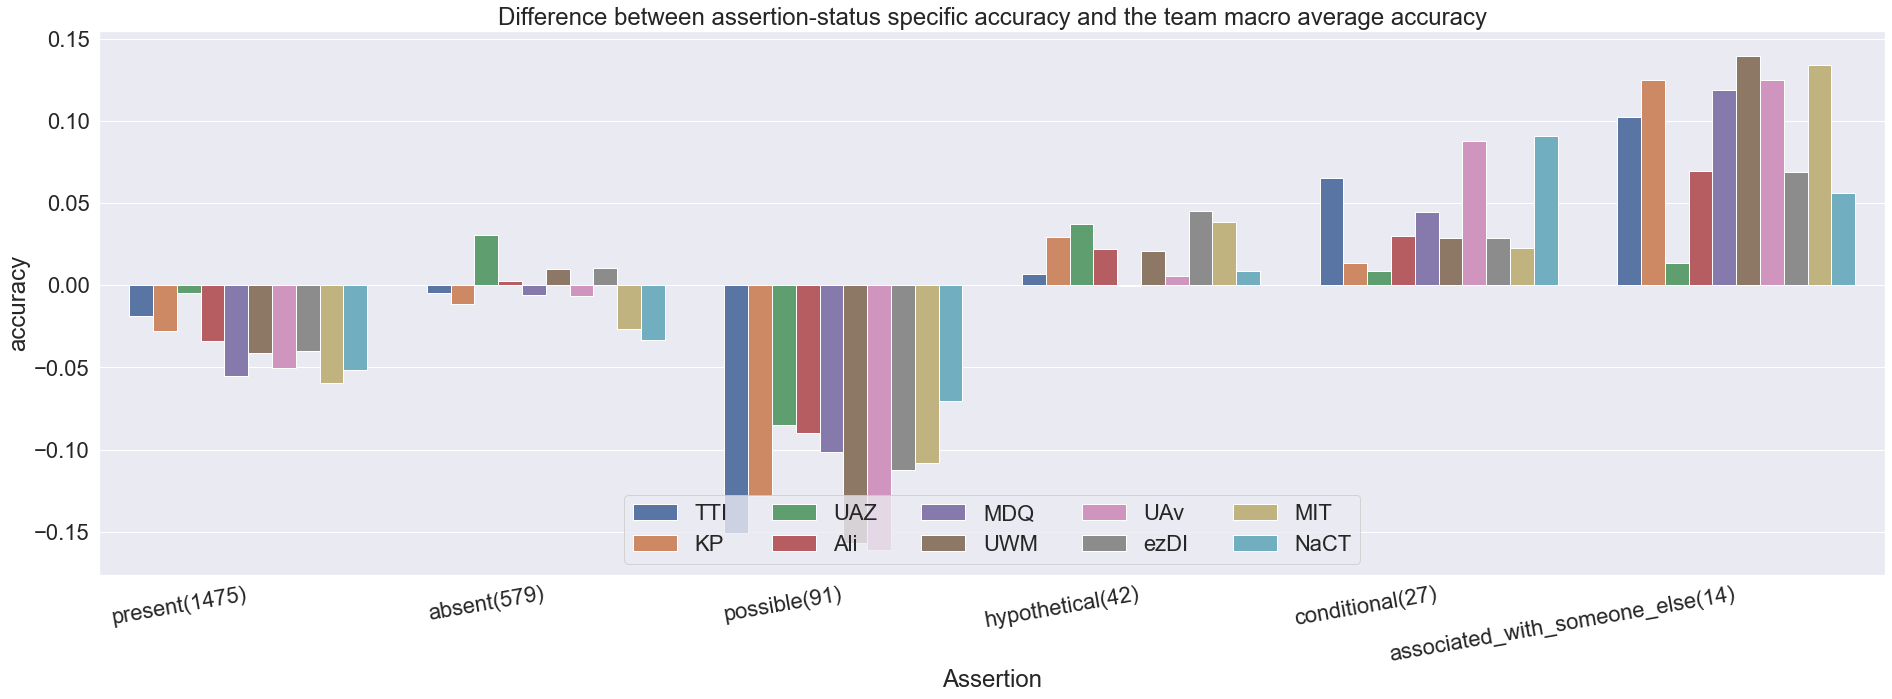

In [373]:
res_diff = res.copy()
res_diff.iloc[:, 2:] = res.iloc[:, 2:].apply(lambda x:x-res.mean(axis=0)[1:], axis=1)

plotdata = pd.melt(res_diff, id_vars=['Assertion', 'counts'], value_vars=[x[0] for x in acc], var_name='team', value_name='accuracy')
ax = sns.barplot(x= 'Assertion', y='accuracy', hue='team', data=plotdata)
ax.tick_params(axis='x', rotation=60)
plt.legend(loc='lower center', ncol=5) # bbox_to_anchor=(0.5, 1.05)
plt.title('Difference between assertion-status specific accuracy and the team macro average accuracy')
ax.set_xticklabels([f'{res.Assertion[i]}({res.counts[i]})' for i in range(2,len(res.index)+2)], ha='right', rotation=10)

plt.savefig("Accuracy-diff-macro-by-assertion.png", bbox_inches='tight')
plt.show()

In [356]:
# sem type vs section 

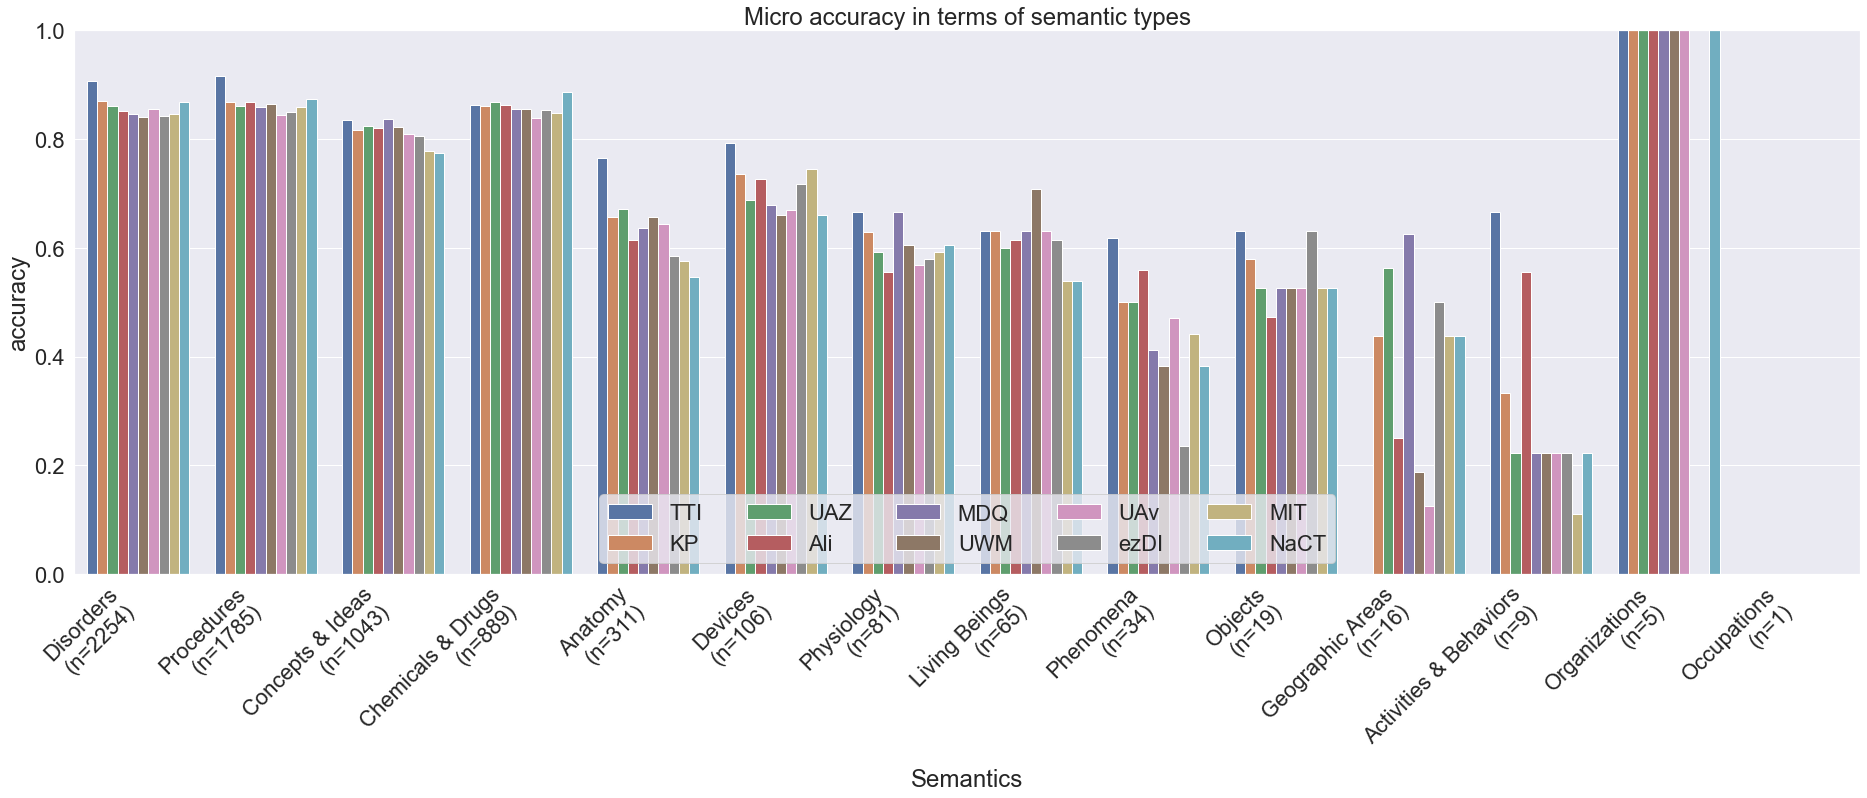

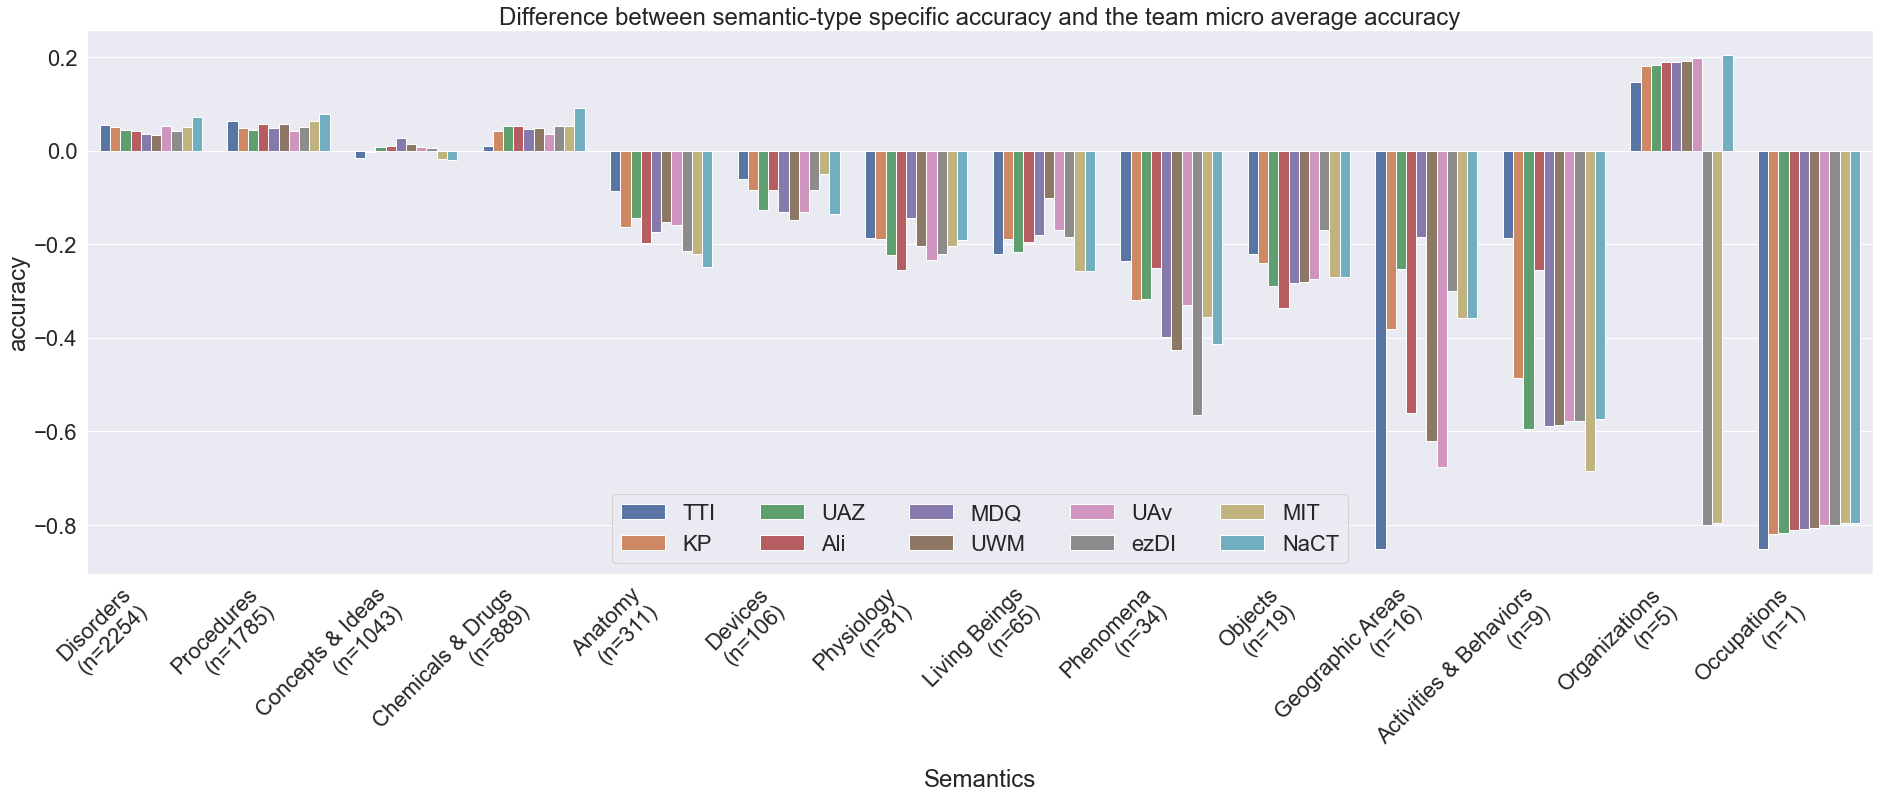

In [357]:
# sem type vs accuracy 
res = gold.sem_type.value_counts().rename_axis(['Semantics']).reset_index(name='counts')
for team in os.listdir(DIR_TEAM_OUT):
    with open(os.path.join(DIR_TEAM_OUT, team), 'r') as f:
        lines = f.readlines()
    if len(lines) != len(gold.index):
        print(team)
        continue
    tmpres = pd.DataFrame({'sem_type':gold.sem_type.reset_index(drop=True), 'out':pd.Series(lines).str.strip() == gold.CUI.reset_index(drop=True)})
    tmpres = tmpres.groupby(['sem_type'])['out'].sum().rename_axis(['Semantics']).reset_index(name=team[11:-4])
    res = pd.merge(res, tmpres, how='outer', on=['Semantics'])
res = res[["Semantics", "counts"]+[x[0] for x in acc]]
res.iloc[:, 2:] = res.iloc[:, 2:].apply(lambda x: x/res.counts, axis=0)

plotdata = pd.melt(res, id_vars=['Semantics', 'counts'], value_vars=[x[0] for x in acc], var_name='team', value_name='accuracy')
ax = sns.barplot(x= 'Semantics', y='accuracy', hue='team', data=plotdata)
plt.legend(loc='lower center', ncol=5) # bbox_to_anchor=(0.5, 1.05)
plt.ylim(0,1)
plt.title('Micro accuracy in terms of semantic types')
ax.set_xticklabels([f'{res.Semantics[i]}\n(n={res.counts[i]})' for i in range(len(res.index))], ha='right', rotation=45)

plt.savefig("Accuracy-by-semantic.png", bbox_inches='tight')
plt.show()

res_diff = res.copy()
res_diff.iloc[:, 2:] = res.iloc[:, 2:].apply(lambda x:x-[x[1] for x in acc], axis=1)

plotdata = pd.melt(res_diff, id_vars=['Semantics', 'counts'], value_vars=[x[0] for x in acc], var_name='team', value_name='accuracy')
ax = sns.barplot(x= 'Semantics', y='accuracy', hue='team', data=plotdata)
plt.legend(loc='lower center', ncol=5) # bbox_to_anchor=(0.5, 1.05)
plt.title('Difference between semantic-type specific accuracy and the team micro average accuracy')
ax.set_xticklabels([f'{res.Semantics[i]}\n(n={res.counts[i]})' for i in range(len(res.index))], ha='right', rotation=45)

plt.savefig("Accuracy-diff-micro-by-semantic.png", bbox_inches='tight')
plt.show()

Concept normalization by CUI type

## Error analysis 

In [496]:
thesections = gold.groupby('section').s.size().sort_values(ascending=False)[:10].index
thesections

Index(['Hospital course', 'Present illness', 'Physical examination/Status',
       'Investigations/Results', 'Medications', 'Past history', 'Diagnoses',
       'Follow-up/Instructions', 'Procedures/Surgery', 'Unknown/Unclassified'],
      dtype='object', name='section')

In [469]:
gold

,b,e_x,t,a,c,s,filename,item,cui_id,CUI,e_y,section,concept,CUI-index,idx,sem_type,sem_details
0,232.0,244.0,problem,present,hiv positive,Present illness,0002,T1,N000,C0019699,244,Present illness,HIV positive,0.0,0,Phenomena,Laboratory or Test Result
1,280.0,304.0,problem,present,left upper quadrant pain,Present illness,0002,T2,N001,C0238552,304,Present illness,left upper quadrant pain,1.0,1,Disorders,Sign or Symptom
2,316.0,322.0,problem,present,nausea,Present illness,0002,T3,N002,C0027497,322,Present illness,nausea,2.0,2,Disorders,Sign or Symptom
3,327.0,335.0,problem,present,vomiting,Present illness,0002,T4,N003,C0042963,335,Present illness,vomiting,3.0,3,Disorders,Sign or Symptom
4,345.0,370.0,problem,present,a long standing complaint,Present illness,0002,T5,N004,CUI-less,370,Present illness,a long-standing complaint,4.0,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6920,6573.0,NaN,NaN,N/A-No_mapping,NaN,NaN,920798564,NaN,N235,C0376358,6584,Hospital course,prostate CA,6920.0,6920,Disorders,Neoplastic Process
6921,643.0,NaN,NaN,N/A-No_mapping,NaN,NaN,920798564,NaN,N236,C1827596,669,Chief complaint,HISTORY OF PRESENT ILLNESS,6921.0,6921,Disorders,Finding
6922,7168.0,7175.0,treatment,N/A-non-problems,niferex,Medications,920798564,T167,N237,C0212018,7190,Medications,Niferex 150 milligrams,6922.0,6922,Chemicals & Drugs,Organic Chemical
6923,220.0,240.0,problem,present,significant problems,Diagnoses,920798564,T4,N193,C0750502,231,Diagnoses,SIGNIFICANT,6923.0,6923,Concepts & Ideas,Idea or Concept


In [491]:
gold2 = gold.copy()
gold2[['section_count']] = gold.groupby('section').CUI.transform('count')
gold2[['char_len']]= gold.e_y - gold.b
gold2 = gold2[gold2.char_len < 21]
gold2.char_len = gold2.char_len.astype(int).astype("category")
gold2

,b,e_x,t,a,c,s,filename,item,cui_id,CUI,e_y,section,concept,CUI-index,idx,sem_type,sem_details,section_count,char_len
0,232.0,244.0,problem,present,hiv positive,Present illness,0002,T1,N000,C0019699,244,Present illness,HIV positive,0.0,0,Phenomena,Laboratory or Test Result,1211,12
2,316.0,322.0,problem,present,nausea,Present illness,0002,T3,N002,C0027497,322,Present illness,nausea,2.0,2,Disorders,Sign or Symptom,1211,6
3,327.0,335.0,problem,present,vomiting,Present illness,0002,T4,N003,C0042963,335,Present illness,vomiting,3.0,3,Disorders,Sign or Symptom,1211,8
5,471.0,483.0,problem,present,hiv positive,Present illness,0002,T6,N005,C0019699,483,Present illness,HIV positive,5.0,5,Phenomena,Laboratory or Test Result,1211,12
6,527.0,545.0,treatment,N/A-non-problems,blood transfusions,Present illness,0002,T7,N006,C0005841,545,Present illness,blood transfusions,6.0,6,Procedures,Therapeutic or Preventive Procedure,1211,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6918,5683.0,NaN,NaN,N/A-No_mapping,NaN,NaN,920798564,NaN,N233,C0428284,5694,Hospital course,electrolyte,6918.0,6918,Chemicals & Drugs,Pharmacologic Substance,2099,11
6919,6559.0,NaN,NaN,N/A-No_mapping,NaN,NaN,920798564,NaN,N234,C0205179,6572,Hospital course,well advanced,6919.0,6919,Concepts & Ideas,Qualitative Concept,2099,13
6920,6573.0,NaN,NaN,N/A-No_mapping,NaN,NaN,920798564,NaN,N235,C0376358,6584,Hospital course,prostate CA,6920.0,6920,Disorders,Neoplastic Process,2099,11
6923,220.0,240.0,problem,present,significant problems,Diagnoses,920798564,T4,N193,C0750502,231,Diagnoses,SIGNIFICANT,6923.0,6923,Concepts & Ideas,Idea or Concept,235,11


<AxesSubplot:xlabel='char_len', ylabel='plot'>

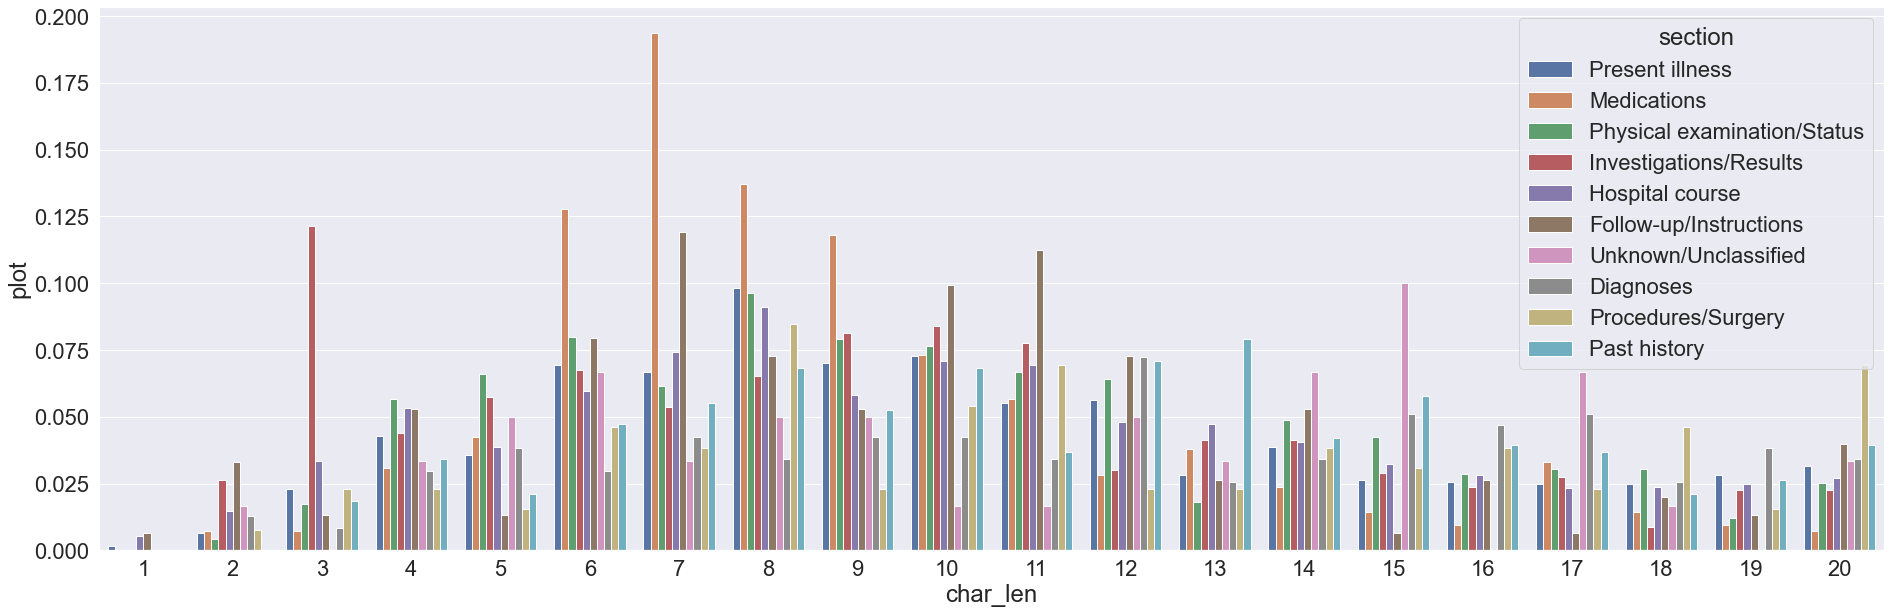

In [497]:
gold2[['plot']]=gold2[gold2.section.isin(thesections)].groupby(['char_len', 'section']).CUI.transform('count')/gold2.section_count
sns.barplot(x='char_len', y='plot', hue='section', data=gold2.loc[gold2.section.isin(thesections), ['char_len', 'section', 'plot']])

Difficult: 

    hospital course, procedures/surgery, and reasons/indications
    
Easy: 

    medications and past history

<AxesSubplot:xlabel='word_len', ylabel='plot'>

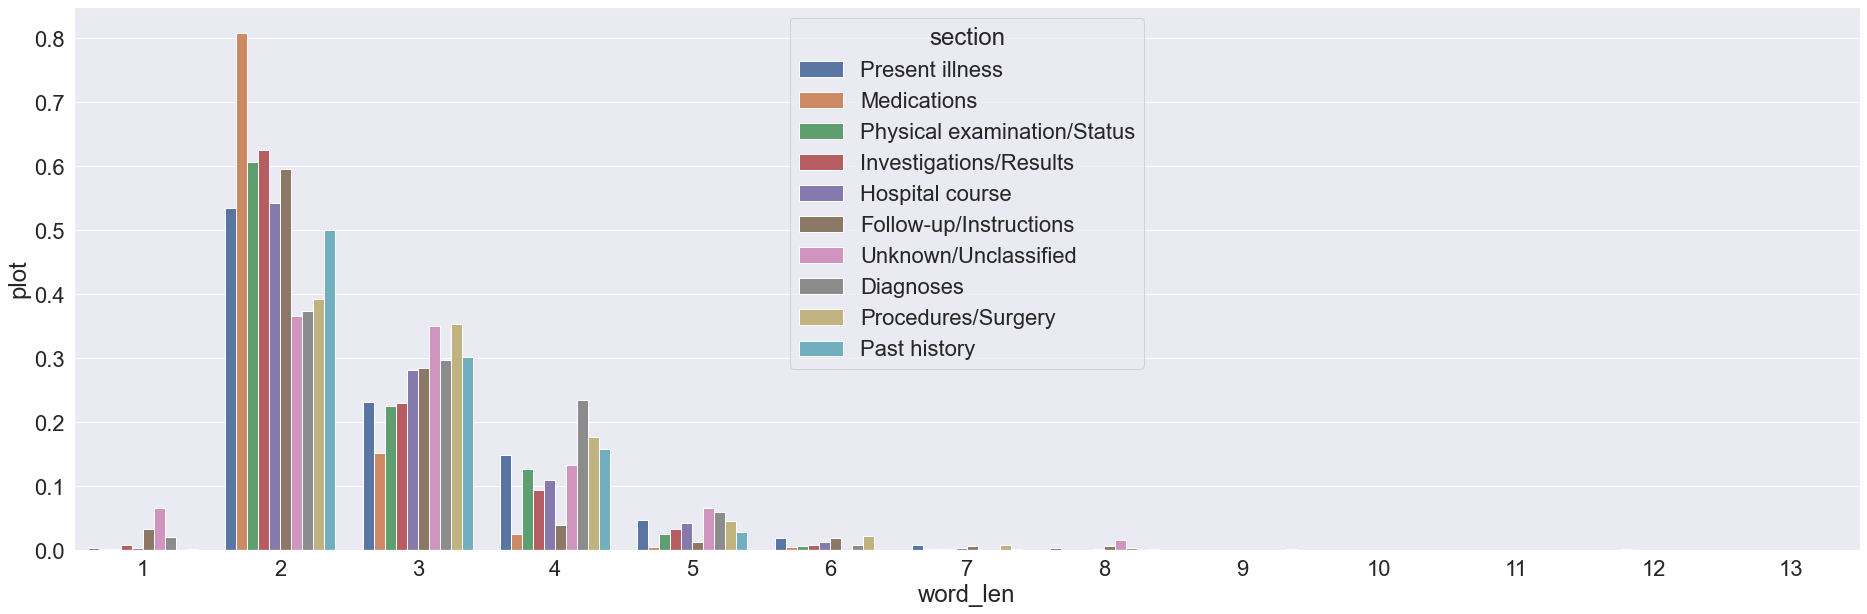

In [517]:
gold2 = gold.copy()
gold2[['section_count']] = gold.groupby('section').CUI.transform('count')
gold2[['word_len']]= gold.concept.apply(lambda x: len(x.split(' ')))
# gold2 = gold2[gold2.word_len < 21]
gold2.word_len = gold2.word_len.astype(int).astype("category")
gold2
gold2[['plot']]=gold2[gold2.section.isin(thesections)].groupby(['word_len', 'section']).CUI.transform('count')/gold2.section_count
sns.barplot(x='word_len', y='plot', hue='section', data=gold2.loc[gold2.section.isin(thesections), ['word_len', 'section', 'plot']])

0       3
1       5
2       2
3       2
4       4
       ..
6920    3
6921    5
6922    4
6923    2
6924    2
Name: concept, Length: 6925, dtype: int64